In [1]:
import  face_recognition as fr
import numpy as np
import pandas as pd
from glob import glob

import cv2
from tqdm import tqdm
import matplotlib.pyplot as plt

import requests
from io import BytesIO
from PIL import Image
import os
import base64

In [2]:
image_files = glob('images/*')

In [3]:
def download_image(url : str, image_file_path : str) -> str:
    r = requests.get(url, timeout=2.0)
    image_name = os.path.join(image_file_path, url.split('/')[-1])
    if r.status_code != requests.codes.ok:
        assert False, 'Status code error: {}.'.format(r.status_code)

    with Image.open(BytesIO(r.content)) as im:
        im.save(image_name)
    return image_name

In [4]:
def find_biggest_bounding_box(bounding_boxes):
    """
    Given a list of bounding boxes, return the coordinates of the biggest bounding box.

    Parameters:
    - bounding_boxes (list): List of bounding boxes in the format (top, right, bottom, left).

    Returns:
    - biggest_box (tuple): Coordinates of the biggest bounding box in the format (top, right, bottom, left).
    """
    return max(bounding_boxes, key=lambda box: (box[2] - box[0]) * (box[1] - box[3]), default=None)


def extract_face_encodings(image_file):
    try:
        image = fr.load_image_file(image_file)
        face_locations = fr.face_locations(image, model="hog")
        bigger_face = find_biggest_bounding_box(face_locations)
        face_encodings = fr.face_encodings(image, [bigger_face])
        return face_encodings[0]
    except:
        print('Failed to process image')
        return None

In [39]:
def find_matches(url, known_face_encodings):
    image_path = download_image(url, 'images_tmp')
    face_enc = extract_face_encodings(image_path)
    matches = fr.compare_faces(known_face_encodings, face_enc, 0.4)
    os.remove(image_path)
    return max(matches)

In [24]:
df_urls = pd.read_csv('dataset/face_reco_urls.csv')
df_face_encs = pd.read_csv('dataset/face_encodings_processed.csv')
df_face_encs['face_encoding'] = df_face_encs['blob_face_encoding'].apply(lambda x: np.frombuffer(base64.b64decode(x), dtype=np.float64))

In [43]:
df_face_encs = pd.concat([df_face_encs, df_face_encs])
print(len(df_face_encs))

4014080


In [44]:
known_face_encodings = np.vstack(df_face_encs['face_encoding'])

In [46]:
url = df_urls['docUrl'].iloc[-1]
find_matches(url, known_face_encodings)

False

In [4]:
image_dataset = []
for image_file in tqdm(image_files[:10]):
    face_enc = extract_face_encodings(image_file)
    image_dataset.append([image_file, face_enc])

  0%|          | 0/10 [00:00<?, ?it/s]

 40%|████      | 4/10 [00:08<00:12,  2.13s/it]

Failed to process image


100%|██████████| 10/10 [00:23<00:00,  2.32s/it]


In [14]:
df_face_encs = pd.DataFrame(image_dataset, columns=['image_name', 'face_encoding'])
df_face_encs.to_csv('dataset/face_encodings_sample.csv')

df_non_processed = df_face_encs[pd.isna(df_face_encs['face_encoding'])]

df_face_encs = df_face_encs[~pd.isna(df_face_encs['face_encoding'])]

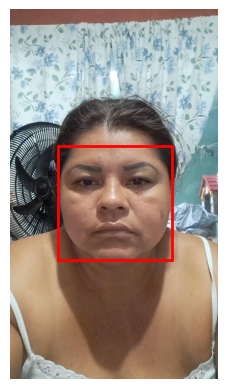

In [37]:
# Convert image to PIL format for easier plotting
image_pil = Image.fromarray(image)

# Find the biggest bounding box
biggest_box = None
max_area = 0

for face_location in face_locations:
    top, right, bottom, left = face_location
    area = (bottom - top) * (right - left)
    
    if area > max_area:
        max_area = area
        biggest_box = face_location

# Plot the image with the biggest bounding box
fig, ax = plt.subplots(1)
ax.imshow(image_pil)

# Add the biggest bounding box to the plot
if biggest_box is not None:
    top, right, bottom, left = biggest_box
    rect = patches.Rectangle((left, top), right - left, bottom - top, linewidth=2, edgecolor='r', facecolor='none')
    ax.add_patch(rect)

# Turn off axis labels
ax.axis('off')

# Show the plot
plt.show()

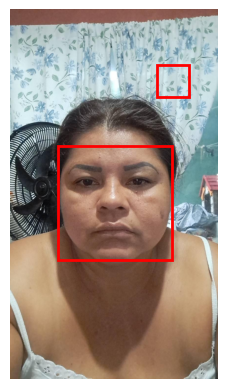

In [36]:
import matplotlib.patches as patches
from PIL import Image

two_faces = df_face_encs['image_name'].iloc[95]
image = fr.load_image_file(two_faces)
face_locations = fr.face_locations(image, model="hog")
face_encodings = fr.face_encodings(image, face_locations)

# Convert image to PIL format for easier plotting
image_pil = Image.fromarray(image)

# Plot the image with bounding boxes
fig, ax = plt.subplots(1)
ax.imshow(image_pil)

# Add bounding boxes to the plot
for face_location in face_locations:
    top, right, bottom, left = face_location
    rect = patches.Rectangle((left, top), right - left, bottom - top, linewidth=2, edgecolor='r', facecolor='none')
    ax.add_patch(rect)

# Turn off axis labels
ax.axis('off')

# Show the plot
plt.show()

In [26]:
known_face_encodings = np.vstack(df_face_encs['face_encoding'])
input_face = df_face_encs['face_encoding'].sample(1).iloc[0]
matches = fr.compare_faces(known_face_encodings, input_face, 0.4)
matches

[False, False, True, False, False, False, False, False, False]

In [ ]:
query = 'SELECT id_user, name, last_name, face_id_1, face_id_2 from profiles'
df_face_encodings  = self.obj_db.consult(query,modification=False)
df_face_encodings  = pd.DataFrame(data = df_face_encodings , columns= ["id_user", "name", "last_name", "face_id_1", "face_id_2"])
face_id_cols = [x for x in df_face_encodings.columns if 'face_id' in x.lower()]
for col in face_id_cols:
    df_face_encodings[col] = df_face_encodings[col].apply( self.obj_db.blob2array )

df_face_encodings = pd.melt(df_face_encodings, id_vars = ['id_user','name','last_name'], value_vars = face_id_cols, var_name='Face_id', value_name='Encoding')
df_face_encodings = df_face_encodings[df_face_encodings['Encoding'].map(len) == 128]

known_face_encodings = np.vstack(df_face_encodings['Encoding'])

matches = fr.compare_faces(known_face_encodings, self.FaceCode, 0.4)
print ("MATCHES COMPARED: {}".format (matches))
if True in matches:
    print('User detected')
    user = df_face_encodings[matches]
    self.__user_id  = user['id_user'].values[0]
    self.__user_name= user['name'].values[0]
    print('Bienvenido {} {} !'.format(user['name'].values[0] , user['id_user'].values[0] ))

    if not self.__plan_check() :
        self.__last_desition(res = False)
        return False

    if self.__matrType > 0 :
        if not self.__matr_check() :
            self.__last_desition(res = False)
            return False

    return True
else:
    return False
return